In [1]:
import sys, os
sys.path.insert(0, '..')
import time

import numpy as np
import matplotlib.pyplot as plt
import scipy.misc as sm
from skimage import color, segmentation
from skimage.future import graph

from lib.segmentation.algorithm import slic, quickshift, felzenszwalb
from lib.dataset.mnist import MNIST

%matplotlib inline

def scale(image):
    image = np.repeat(image, 8, axis=0)
    image = np.repeat(image, 8, axis=1)
    return image

# MNIST
Load a single image from the MNIST test dataset.

Extracting /tmp/mnist/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/t10k-labels-idx1-ubyte.gz
Label: 7


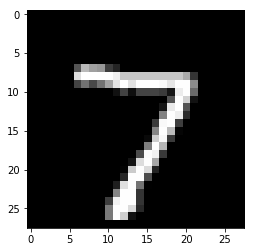

In [2]:
mnist = MNIST(data_dir='/tmp/mnist')
image, label = mnist.next_test_batch(1)
image = np.reshape(image, (28, 28))
image = color.gray2rgb(image)
print('Label:', label[0])
plt.imshow(image)
scaled_image = scale(image)

## SLIC
Segment image using k-means clustering in Color-(x,y,z) space.

In [3]:
# The (approximate) number of labels in the segmented output image.
NUM_SEGMENTS = 100
# Balances color proximity and space proximity. Higher values give more weight to space proximity,
# making superpixel shapes more square. In SLICO mode, this is the initial compactness.
# This parameter depends strongly on image contrast and on the shapes of objects in the image.
COMPACTNESS = 10.0
# Maximum number of iterations of k-means.
MAX_ITERATIONS = 10
# Width of gaussian smoothing kernel for preprocessing for each dimension of the image.
# The same sigma is applied to each dimension in case of a scalar value. Zero means no
# smoothing.
SIGMA = 0.0

t_start = time.process_time()
slic = slic(image, NUM_SEGMENTS, COMPACTNESS, MAX_ITERATIONS, SIGMA)

print('Execution time: {:.5f}s'.format(time.process_time() - t_start))
print('Number of segments:', np.unique(slic).shape[0])

Execution time: 0.00453s
Number of segments: 68


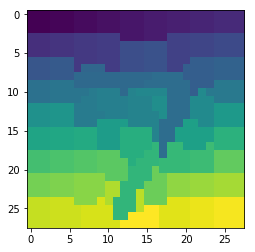

In [4]:
plt.imshow(slic)

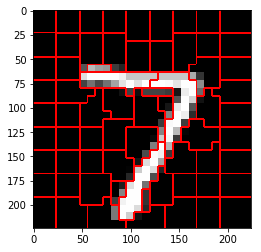

In [5]:
scaled_labels = scale(slic)
boundaries = segmentation.mark_boundaries(scaled_image, scaled_labels, color=(1, 0, 0))
plt.imshow(boundaries)

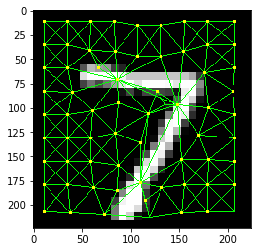

In [6]:
rag = graph.rag_mean_color(scaled_image, scaled_labels)
out = graph.draw_rag(scaled_labels, rag, scaled_image, )
plt.imshow(out)

## Quickshift
Segment image using quickshift clustering in Color-(x,y) space.

In [7]:
# Balances color-space proximity and image-space proximity. Higher values give more weight to color-space.
RATIO = 5
# Width of Gaussian kernel used in smoothing the sample density. Higher means fewer clusters.
KERNEL_SIZE = 5
# Cut-off point for data distances. Higher means fewer clusters.
MAX_DIST = 1
# Width for Gaussian smoothing as preprocessing. Zero means no smoothing.
SIGMA = 0

t_start = time.process_time()
quickshift = quickshift(image, RATIO, KERNEL_SIZE, MAX_DIST, SIGMA)

print('Execution time: {:.5f}s'.format(time.process_time() - t_start))
print('Number of segments:', np.unique(quickshift).shape[0])

Execution time: 0.01500s
Number of segments: 93


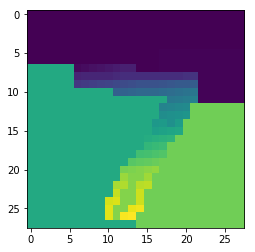

In [8]:
plt.imshow(quickshift)

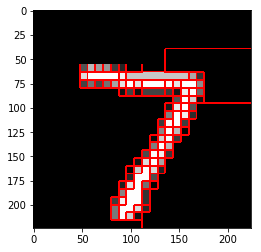

In [9]:
scaled_labels = scale(quickshift)
boundaries = segmentation.mark_boundaries(scaled_image, scaled_labels, color=(1, 0, 0))
plt.imshow(boundaries)

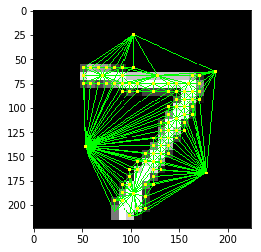

In [10]:
rag = graph.rag_mean_color(scaled_image, scaled_labels)
out = graph.draw_rag(scaled_labels, rag, scaled_image)
plt.imshow(out)

## Felzenszwalb
Compute Felsenszwalb’s efficient graph based image segmentation.

In [11]:
# Higher means larger clusters.
SCALE = 50
# Minimum component size. Enforced using postprocessing.
MIN_SIZE = 1
# Width of Gaussian kernel used in preprocessing.
SIGMA = 0

t_start = time.process_time()
felzenszwalb = segmentation.felzenszwalb(image, SCALE, MIN_SIZE, SIGMA)

print('Execution time: {:.5f}s'.format(time.process_time() - t_start))
print('Number of segments:', np.unique(felzenszwalb).shape[0])

Execution time: 0.00610s
Number of segments: 21


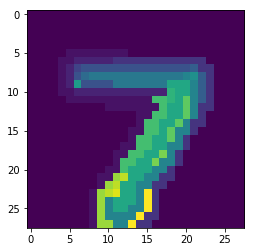

In [12]:
plt.imshow(felzenszwalb)

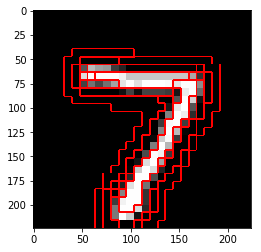

In [13]:
scaled_labels = scale(felzenszwalb)
boundaries = segmentation.mark_boundaries(scaled_image, scaled_labels, color=(1, 0, 0))
plt.imshow(boundaries)

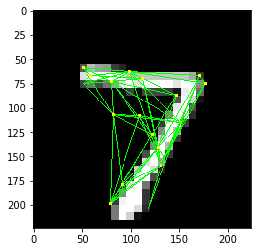

In [14]:
rag = graph.rag_mean_color(scaled_image, scaled_labels)
out = graph.draw_rag(scaled_labels, rag, scaled_image)
plt.imshow(out)